## Simple exercise in learning PyTorch

Here we write a simple LeNet clone and train it on the MNIST dataset

In [0]:
#Code adapted from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html for LeNet in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    # Intialize parent module
    super(Net, self).__init__()

    # 1 input image channel, 6 output channels, 3x3 square convolution
    # kernel
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # If the size is a square you can only specify a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [0]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0191,  0.1660,  0.0801,  0.1287,  0.0108, -0.0892, -0.0179,  0.0718,
         -0.0047, -0.0578]], grad_fn=<AddmmBackward>)


In [0]:
# Now that we have a working LeNet, we train it on MNIST
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
transform = transforms.Compose([
  transforms.Resize((32,32)),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor()
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = (0,1,2,3,4,5,6,7,8,9)

0it [00:00, ?it/s]

9920512it [00:00, 12657172.08it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 312025.12it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5135384.39it/s]                           
8192it [00:00, 131222.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


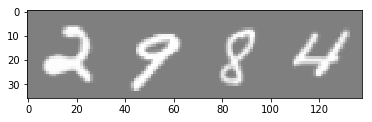

    2     9     8     4


In [0]:
import matplotlib.pyplot as plt
import numpy as np


def show_image(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

images, labels = iter(trainloader).next()

show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.optim as optim

# Ref: https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
criterion = nn.CrossEntropyLoss()

# Ref: https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(2):
   running_loss = 0.0
   for i, data in enumerate(trainloader, 0):
     inputs, labels=data
     optimizer.zero_grad()

     outputs = net(inputs)
     loss = criterion(outputs, labels)
     loss.backward()
     optimizer.step()

     running_loss += loss.item()
     if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finished Training')

In [0]:
images, labels = iter(testloader).next()

show_image(torchvision.utils.make_grid(images))

print(f'Ground Truth: {classes[labels[j]] for j in range(4)}')

outputs = net(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [0]:
# Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))